In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special

Populating the interactive namespace from numpy and matplotlib


# Example 1: log scaled plots
Suppose we are plotting
$$y = f(x).$$
Log plots are useful when either $x$ and/or $y$ range over several orders of magnitude (factors of 10). In our error and convergence plots, both $x$ and $y$ range over many factors of 10, so we use log scales on both axes. Below is an example that compares the linear scale (left), the plot of $\log(y)$ vs $\log(x)$ (middle), and using the `loglog()` Python plotting function (right). 

The difference between plotting of $\log(y)$ vs $\log(x)$ and using the `loglog()` Python plotting function is the how the $x$ and $y$ axis get labeled. (Notice that the actual curves are identical in shape.) The `loglog()` Python plotting function labels the values of $y$ even thought it is plotting the curve $\log(y)$ and likewise for $x$. Since the $\log()$ function is not a linear function, the tick marks on the scales are not evenly spaced.

Let $s = \log(x)$ so that $x = e^s$. For a function $f(x) = x^m$, $m\geq 1$, the effect of a *double* logarithmic scale is a curve identical in shape to $\log(x^m) = \log(e^{ms}) = ms$. Hence, this type of function appears linear, with the exponent $m$ determining the slope of the line.

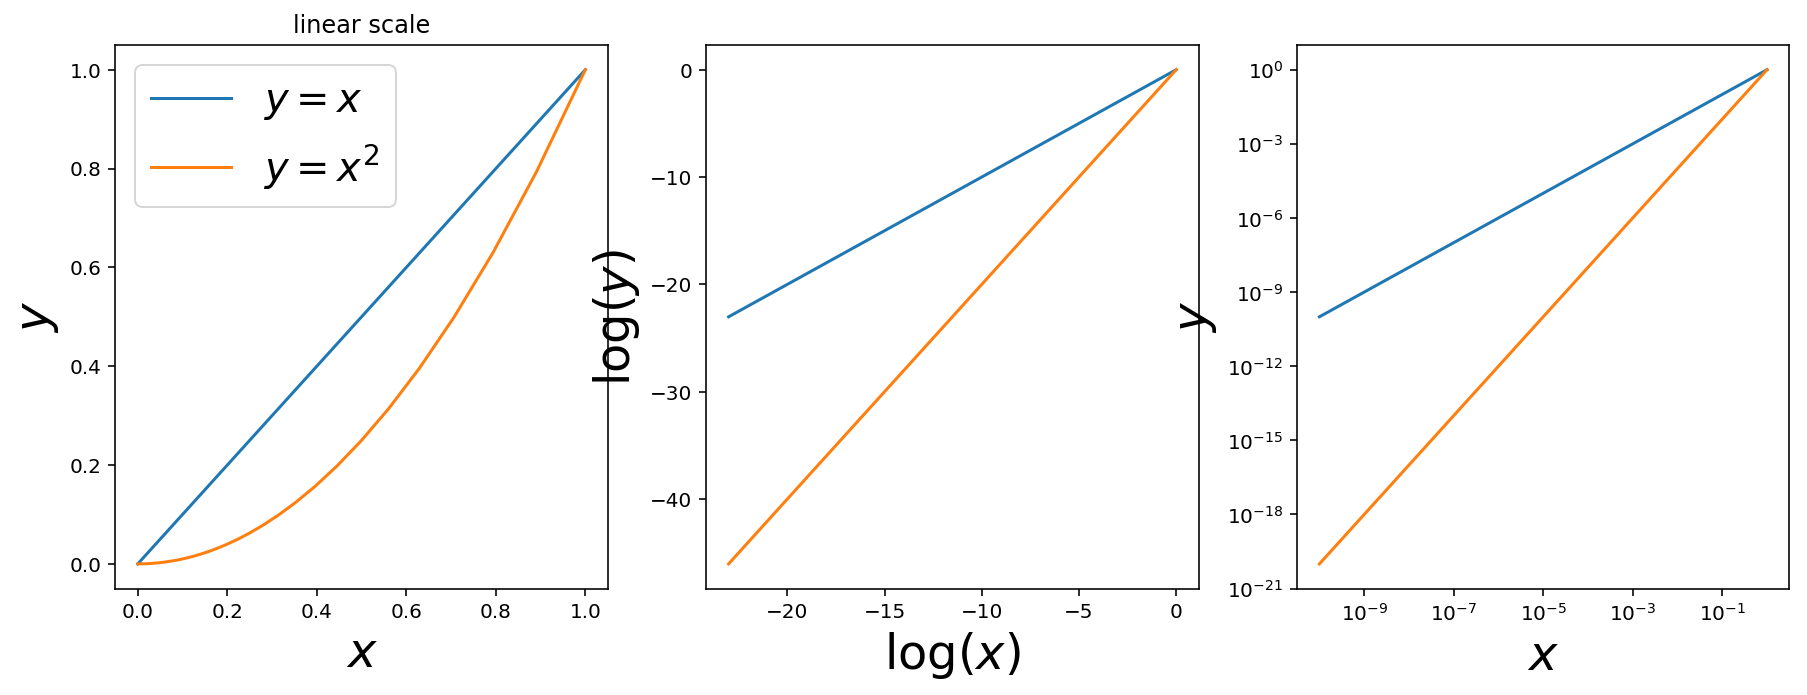

In [2]:
x = logspace(-10, 0, 200)
y1 = x
y2 = x**2

fig = figure(1, [15, 5])

fig.add_subplot(131)
plot(x, y1, label='$y=x$')
plot(x, y2, label='$y=x^2$')
title('linear scale')
legend(fontsize=20) ## figure legend, uses the optional `label=''` parameter in the plot commands
                    ## note that these labels use LaTeX, so are of the form `'$ some math $'`
                    ## sometime LaTeX symbols confuse Python, so it is better to use `r'$ some math$'`
xlabel(r'$x$', fontsize=24) ## x axis label
ylabel(r'$y$', fontsize=24) ## y axis label

fig.add_subplot(132)
plot(log(x), log(y1))
plot(log(x), log(y2))
xlabel(r'$\log(x)$', fontsize=24) ## x axis label
ylabel(r'$\log(y)$', fontsize=24) ## y axis label

fig.add_subplot(133)
loglog(x, y1)
loglog(x, y2)
xlabel(r'$x$', fontsize=24) ## x axis label
ylabel(r'$y$', fontsize=24); ## y axis label

# Example 3: Floating point overflow and underflow
When computing distributions that are exponential functions of a random variable, we frequently run into floating point overflow and underflow. Because of this, we usually work with log probabilities and log likelihoods. Here are a few examples.

## In these examples, we can amplify issues with floating point error for illustration purposes by working with 32bit float (instead of the default 64bit float)

In [3]:
## We can convert 64bit floats to 32bit floats with the function `float32()`
## (FYI, there is also a function `float64()`)
x64 = rand(1) ## a simple uniform random variable between zero and one. float64 by default.
x32 = float32(x64)
rel_err = absolute(x64 - x32)/x64
print(rel_err)

[1.51072648e-08]


## Largest and smallest absolute values
Note that the real smallest absolute value is much smaller than our theoretical limit due to **subnormal numbers**, which we will not study in this class.

In [4]:
## For float64
## find smallest (approximate) value that causes overflow
x64_largest = 2.*2.**1023
## find the largest (approximate) value that caues underflow
x64_smallest = 1e-324
print(x64_largest, x64_smallest)

inf 0.0


In [5]:
## For float32
## find smallest (approximate) value that causes overflow
x32_largest = float32(2.*2.**127)
## find the largest (approximate) value that caues underflow
x32_smallest = float32(1.)/float32(1e38)/float32(1e8) 
print(x32_largest, x32_smallest)

inf 0.0


## This example illustrates underflow in computing the Poisson distribution
The Poisson distribution is given by
$$ P(n | \lambda) = e^{-\lambda}\frac{\lambda^n}{n!}.$$
Recall that $n! = n(n-1)(n-2)\cdots 3\cdot 2\cdot 1 = \Gamma(n+1),$ where $\Gamma(x)$ is the so called gamma function.

In [6]:
from scipy.special import gamma
def dpoisson(n, lam):
    return exp(-lam)*lam**n/gamma(n+1)
print(dpoisson(10, 0.5))
print(dpoisson(50, 0.01))
print(dpoisson(100, 0.01)) ## this should be nonzero

1.6322616219566209e-10
3.2552337733133353e-165
0.0


## We encounter both overflow and underflow when working with the Binomial distribution
The Binomial distribution is give by
$$ P(k \mid n, p) = \binom{n}{k}p^k(1-p)^{n-k}$$

In [2]:
from scipy.special import loggamma

def dbinomial(k, n, p):
    return gamma(n + 1)/gamma(k + 1)/gamma(n - k + 1)*p**k*(1 - p)**(n-k)

## We can create a more stable version of our function with the following
## The strategy is to compute log(P) first and then return exp(log(P))
## We make use of the built in function loggamma(x) = log(gamma(x))
def dbinomial_2(k, n, p):
    log_prob = loggamma(n + 1) - loggamma(k + 1) - loggamma(n - k + 1) + k*log(p) + (n-k)*log(1-p)
    return exp(log_prob)


print(dbinomial(15, 20, 0.01)) # everything is fine with these values
print('----------------------')

print(dbinomial(100, 200, 0.5)) # overflow in the `gamma` function
print(gamma(200), 0.5**100) # overflow but not underflow
print('corrected version:', dbinomial_2(100, 200, 0.5)) # true value is not very small or large!!

print('----------------------')
print(dbinomial(15, 200, 0.01)) 
print(gamma(200), 1/gamma(200-15), 0.01**(200 - 15)) ## overflow and underflow, 0*inf = nan
print('corrected version:', dbinomial_2(15, 200, 0.01))

1.3295378782200018e-31
----------------------
1.0981223221879045e-62
196.8421026905665 7.888609052210118e-31
corrected version: 0.0563484790092559
----------------------
1.2032832326722471e-32
179.83383368412464 0.006421479968813071 0.0
corrected version: 2.278966811808424e-09


# Let's put this all together into a "class"

In [3]:
class Binomial:
    """A Binomial random variable with parameters `n` and `p`."""
    
    def __init__(self, n, p):
        """This method gets called once only when you create an instance"""
        self.n = n
        self.p = p
        
    def log_prob(self, k):
        s = loggamma(self.n + 1) - loggamma(k + 1) - loggamma(self.n - k + 1) 
        return s + k*log(self.p) + (self.n - k)*log(1-self.p)
    
    def prob(self, k):
        return exp(self.log_dbinomial(k))
    
    def sample(self, Nsamples):
        """We could have a method for sampling a binomial random variable.
        We might implement this later in the course."""
        return NotImplementedError ## In other words, it doesn't work yet...

In [4]:
b = Binomial(200, 0.5) ## create an instance of the `Binomial` class
b.dbinomial(100)

0.0563484790092559

# Example 4: Computing empirical variance
The variance of a random variable $X$ with mean $\mu$ is defined as $E[(X - \mu)^2]$. Suppose we have $N$ independent and identically distributed (iid) random samples $x_i$, $i=1,\ldots,N$. The empirical mean is given by
$$ \bar{x} = \frac{1}{N}\sum_{i=1}^N x_i.$$
There are two different (mathematically equivalent) ways we can compute the empirical variance

  1. Version 1
  $$ \hat{\sigma}^2_{V1} = \frac{1}{N}\sum_{i=1}^N (x_i - \bar{x})^2$$
  2. Version 2
  $$ \hat{\sigma}^2_{V2} = \left[\frac{1}{N}\sum_{i=1}^N x_i^2\right] - \bar{x}^2$$

We might think that version 2 is preferable since it uses fewer floating point operations to compute. However, if we consider the floating point cancellation error incurred, we find that in certain situations, version 2 is far less accurate than version 1.

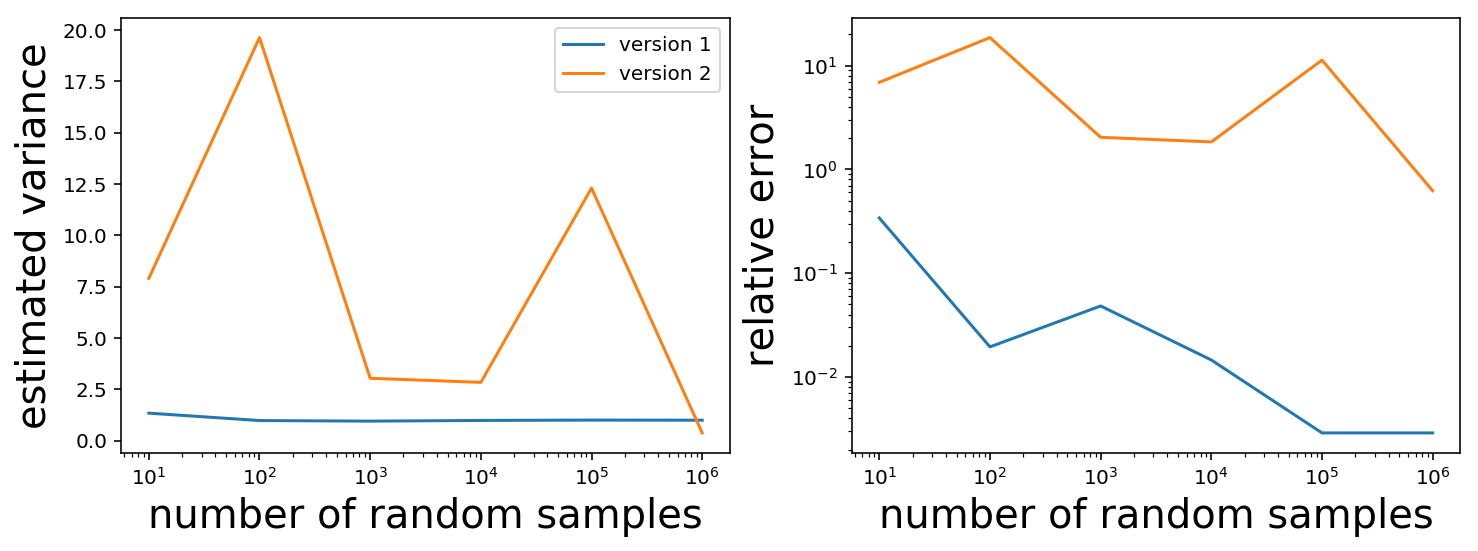

In [8]:
N_points = 6
exact_mean = 10000.
exact_variance = 1.

x_variance_version_1 = zeros(N_points)
x_variance_version_2 = zeros(N_points)

for j in arange(N_points):
    N = 10**(1 + j)
    x64 = normal(exact_mean, sqrt(exact_variance), N)
    x = float32(x64)
    ## there is a built in function `mean`, but we wont use it here
    x_mean = sum(x)/N
    x_variance_version_1[j] = sum((x - x_mean)**2)/N
    x_variance_version_2[j] =  sum(x**2)/N - x_mean**2


abs_err_1 = absolute(exact_variance - x_variance_version_1)
abs_err_2 = absolute(exact_variance - x_variance_version_2)

rel_err_1 = abs_err_1/exact_variance
rel_err_2 = abs_err_2/exact_variance

Nlist = 10**arange(1, N_points+1)

### Make a nice figure
fig = figure(1, [12, 4])

fig.add_subplot(121)
semilogx(Nlist, x_variance_version_1, label='version 1')
semilogx(Nlist, x_variance_version_2, label='version 2')
legend()
xlabel('number of random samples', fontsize=20)
ylabel('estimated variance', fontsize=20)

fig.add_subplot(122)
loglog(Nlist, abs_err_1)
loglog(Nlist, abs_err_2)
xlabel('number of random samples', fontsize=20)
ylabel('relative error', fontsize=20);

## What would happen if we used `float64` values instead?

# Example 5: distribution of floating point numbers
We will create a histogram of all possible positive float16 numbers.

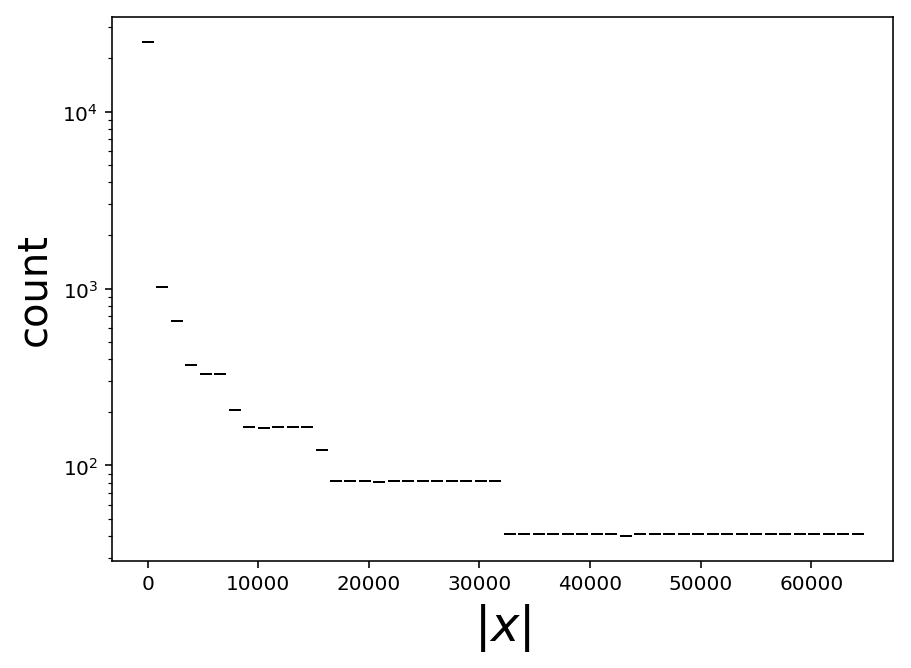

In [9]:
import itertools
x = [] ## We will build the array using a list, one element at a time
for d in itertools.product(*[[0, 1] for j in arange(10)]): ## loop over all possible binary words with 10 digits
    x16 = float16(1. + sum(d/2**arange(1, 11)))
    x.append(x16)
mantissa = array(x) ## 10 bits
exponent = (2.**arange(-14, 16)) ## 5 bits
all_positive_float16 = (mantissa[None, :]*exponent[:, None]).flatten() ## use broadcasting to get all possible values

h, xbins = histogram(all_positive_float16, bins=50)

figure(1, [7, 5])
# plot(xbins[:-1], h, '_') # regular plot doesn't show clearly, need a log scale on the y axis
semilogy(xbins[:-1], h, '_k')
# semilogx(xbins[:-1], h, '*-')
xlabel(r'$|x|$', fontsize=24)
ylabel('count', fontsize=20);